<a href="https://colab.research.google.com/github/Anirudh553/NLP-projects/blob/main/nlp_banana_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install transformers
!pip install scikit-learn


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

emotion_dataset_100k.csv:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99746 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'emotion'],
        num_rows: 89771
    })
    test: Dataset({
        features: ['sentence', 'emotion'],
        num_rows: 9975
    })
})


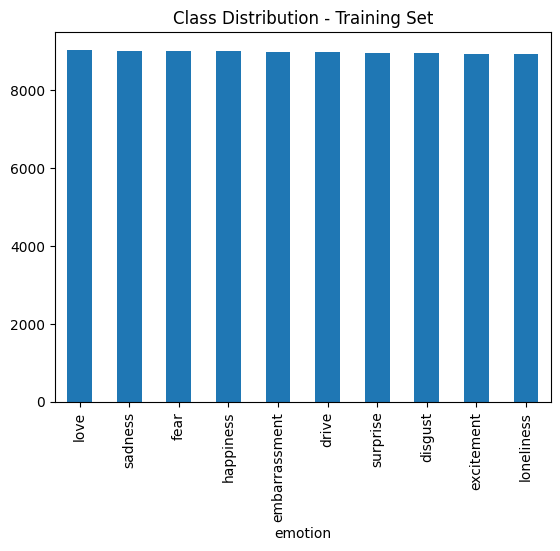

['disgust', 'drive', 'embarrassment', 'excitement', 'fear', 'happiness', 'loneliness', 'love', 'sadness', 'surprise']


In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

dataset = load_dataset("shreyaspullehf/emotion_dataset_100k")

dataset = dataset["train"].train_test_split(test_size=0.1)

print(dataset)
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

train_df.head()

train_df["emotion"].value_counts().plot(kind="bar")
plt.title("Class Distribution - Training Set")
plt.show()

label_names = sorted(train_df["emotion"].unique())
print(label_names)

num_labels = len(label_names)




In [ ]:
# Create label mapping
label2id = {label: idx for idx, label in enumerate(label_names)}
id2label = {idx: label for label, idx in label2id.items()}

# Convert labels to integers
dataset = dataset.map(lambda x: {"emotion": label2id[x["emotion"]]})


Map:   0%|          | 0/89771 [00:00<?, ? examples/s]

Map:   0%|          | 0/9975 [00:00<?, ? examples/s]

In [ ]:
# Use smaller subset for faster training
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(30000))


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(
        example["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9975 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = tokenized_dataset.rename_column("emotion", "labels")
tokenized_dataset = tokenized_dataset.remove_columns(["sentence"])
tokenized_dataset.set_format("torch")


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True)
test_loader = DataLoader(tokenized_dataset["test"], batch_size=32)


In [ ]:
import torch
from transformers import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_names)
)

model.to(device)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
from tqdm import tqdm

epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} Average Loss: {avg_loss:.4f}")


100%|██████████| 938/938 [11:29<00:00,  1.36it/s]



Epoch 1 Average Loss: 0.4556


100%|██████████| 938/938 [11:44<00:00,  1.33it/s]


Epoch 2 Average Loss: 0.1152


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="weighted"
)

print("\n===== Evaluation Metrics =====")
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))




===== Evaluation Metrics =====
Accuracy: 0.9447619047619048
Precision (weighted): 0.9464686352919053
Recall (weighted): 0.9447619047619048
F1 Score (weighted): 0.945057028772768

Confusion Matrix:
[[992   2   2   0   6   2   0   1   4   8]
 [  0 967   0  12   5   8   5   0  17  11]
 [  2   1 971   0   4   1   7   0   4   7]
 [  0  14   0 959   3  25   0   1   1   8]
 [  3   6   0   5 932   1   7   0  20   6]
 [  0   4   4  12   0 960   1   4   6   8]
 [  0   0   0   0   2   0 960   0  93   2]
 [  0   4   1   0   2  27   4 891  11   2]
 [  0   1   0   0   1   0  36   2 945   2]
 [  4  16   9  36   7   9   9   3  20 847]]


In [ ]:
import torch.nn.functional as F

def predict_text(text):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)

    confidence, pred = torch.max(probs, dim=1)

    return label_names[pred.item()], confidence.item()


In [ ]:
print(predict_text("I’ve been working toward this goal for years."))
print(predict_text("I can't wait for tomorrow!"))
print(predict_text("This is the best day of my life."))
print(predict_text("I feel motivated to push harder."))
print(predict_text("I'm feeling salacious."))
print(predict_text("I'm feeling down."))



('drive', 0.9924397468566895)
('excitement', 0.9947136044502258)
('happiness', 0.9961138963699341)
('drive', 0.995218813419342)
('happiness', 0.9789935350418091)
('sadness', 0.9917355179786682)
